TODO:
- prove that oversampling is bad for ada and gb if halving grid search cv is used

# Preparation

## Starting the timer

In [1]:
import time

start_time = time.time()

## Importing and setting global variables

In [2]:
import os
import datetime

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

import imblearn
from imblearn.over_sampling import SMOTE

In [3]:
CSV_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/AppStats Project/data.csv'

TEST_TO_ALL_SIZE = 0.125
VAL_TO_TRAIN_SIZE = 0.1

RSPL_TO_OVER_SIZE = 2

RANDOM_STATE = 42

## Setting up

In [4]:
np.random.seed(RANDOM_STATE)

In [5]:
f2_score = lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2)
f2_scorer = make_scorer(fbeta_score, beta=2)

In [6]:
def plot_mean_test_score(params, mean_test_score):
    plt.plot(params, mean_test_score)
    plt.scatter(params, mean_test_score, s=20, color='red')

In [7]:
def get_params_from_list_of_dict(param_name, l):
    return [d[param_name] for d in l]

In [8]:
def show_cv_results(param_name, cv_results):
    params = get_params_from_list_of_dict(param_name, cv_results['params'])
    df = pd.DataFrame({'iter': cv_results['iter'],
                       param_name: params,
                       'mean_test_score': cv_results['mean_test_score'],
                       'rank_test_score': cv_results['rank_test_score']
                       })
    for iter_index in np.unique(cv_results['iter']):
        df_sub = df[df['iter'] == iter_index]
        plot_mean_test_score(df_sub[param_name], df_sub['mean_test_score'])
    return df

# Data preparation

## Data exploration

In [9]:
df = pd.read_csv(CSV_FILE_PATH)
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [10]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


## Splitting the dataset into training set, validation set, and test set

In [11]:
y = (df['Bankrupt?']).to_numpy()
y

array([1, 1, 1, ..., 0, 0, 0])

In [12]:
X = df.drop('Bankrupt?', axis=1, inplace=False).to_numpy()
X

array([[0.37059426, 0.42438945, 0.40574977, ..., 0.56405011, 1.        ,
        0.01646874],
       [0.46429094, 0.53821413, 0.51673002, ..., 0.57017495, 1.        ,
        0.02079431],
       [0.42607127, 0.49901875, 0.47229509, ..., 0.56370608, 1.        ,
        0.01647411],
       ...,
       [0.47272461, 0.533744  , 0.52063815, ..., 0.5651584 , 1.        ,
        0.09764874],
       [0.50626432, 0.5599106 , 0.55404465, ..., 0.56530151, 1.        ,
        0.04400945],
       [0.49305319, 0.57010467, 0.54954762, ..., 0.56516694, 1.        ,
        0.23390224]])

In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y,
        test_size=TEST_TO_ALL_SIZE, stratify=y,
        random_state=RANDOM_STATE)
print(  X_train_val.shape,
        X_test.shape,
        X_train_val.shape,
        y_test.shape
)

(5966, 95) (853, 95) (5966, 95) (853,)


In [14]:
X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=VAL_TO_TRAIN_SIZE,
        stratify=y_train_val,
        random_state=RANDOM_STATE)
print(  X_train.shape,
        X_val.shape,
        y_train.shape,
        y_val.shape
)

(5369, 95) (597, 95) (5369,) (597,)


(array([0, 1]), array([6599,  220]))
(array([0, 1]), array([5196,  173]))
(array([0, 1]), array([578,  19]))
(array([0, 1]), array([825,  28]))


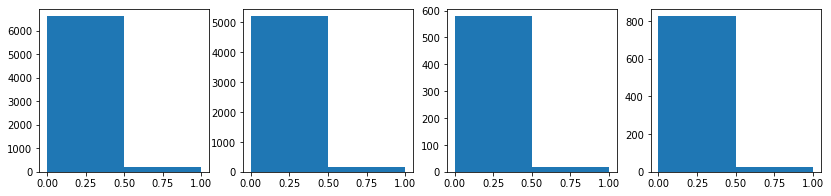

In [15]:
fig, ax = plt.subplots(1, 4)
fig.set_figheight(3)
fig.set_figwidth(14)

ax[0].hist(y, bins=2)
ax[1].hist(y_train, bins=2)
ax[2].hist(y_val, bins=2)
ax[3].hist(y_test, bins=2)

print(np.unique(y, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))
print(np.unique(y_test, return_counts=True))

## Creating a new dataset that SMOTE oversample the training set

In [16]:
X_train_over, y_train_over = SMOTE(
    random_state=RANDOM_STATE).fit_resample(X_train, y_train)

(array([0, 1]), array([5196,  173]))


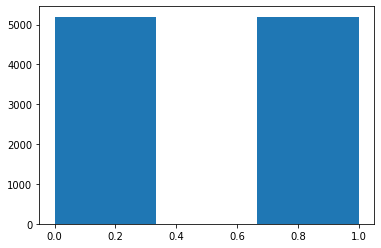

In [17]:
plt.hist(y_train_over, bins=3)
print(np.unique(y_train, return_counts=True))

# Random forest (1/2)

## Setting up parameter grid and Random forest

In [18]:
n_estimators_rf_1 = np.unique(np.linspace(2, 200, num=20, dtype=int))
n_estimators_rf_1

array([  2,  12,  22,  33,  43,  54,  64,  74,  85,  95, 106, 116, 127,
       137, 147, 158, 168, 179, 189, 200])

In [19]:
param_grid_rf_1 = {'n_estimators': n_estimators_rf_1}

In [20]:
rf_1 = RandomForestClassifier(random_state=RANDOM_STATE)
rf_1

RandomForestClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [21]:
clf_rf_1 = HalvingGridSearchCV(rf_1, param_grid_rf_1, scoring=f2_scorer, 
                               random_state=RANDOM_STATE)
clf_rf_1

HalvingGridSearchCV(estimator=RandomForestClassifier(random_state=42),
                    param_grid={'n_estimators': array([  2,  12,  22,  33,  43,  54,  64,  74,  85,  95, 106, 116, 127,
       137, 147, 158, 168, 179, 189, 200])},
                    random_state=42, scoring=make_scorer(fbeta_score, beta=2))

In [22]:
clf_rf_1.fit(X_train_over, y_train_over)

HalvingGridSearchCV(estimator=RandomForestClassifier(random_state=42),
                    param_grid={'n_estimators': array([  2,  12,  22,  33,  43,  54,  64,  74,  85,  95, 106, 116, 127,
       137, 147, 158, 168, 179, 189, 200])},
                    random_state=42, scoring=make_scorer(fbeta_score, beta=2))

In [23]:
clf_rf_1.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2]),
 'mean_fit_time': array([1.18197441e-02, 6.85603619e-02, 1.19018030e-01, 2.81752443e-01,
        4.40097237e-01, 5.23783064e-01, 7.07353449e-01, 8.08557272e-01,
        9.19227600e-01, 1.11830759e+00, 6.29829931e-01, 6.09542704e-01,
        6.67465162e-01, 7.18604660e-01, 7.70296288e-01, 8.32030106e-01,
        8.87933016e-01, 9.50814486e-01, 1.00087514e+00, 1.05266366e+00,
        4.08448744e-01, 7.97727680e-01, 1.96623354e+00, 2.36142182e+00,
        3.66338439e+00, 3.11501484e+00, 6.16274118e-01, 7.66993818e+00,
        1.30448896e+01, 9.28098125e+00]),
 'mean_score_time': array([0.00165501, 0.00296173, 0.00415792, 0.0120532 , 0.01167278,
        0.01446986, 0.02445259, 0.02428503, 0.0279954 , 0.03894548,
        0.01349001, 0.0154047 , 0.01592522, 0.01710649, 0.01830697,
        0.01925416, 0.02100363, 0.02590971, 0.02288747, 0.02466187,
        0.00611162, 0.01070051

,iter,n_estimators,mean_test_score,rank_test_score
0,0,2,0.806542,30
1,0,12,0.928546,29
2,0,22,0.944607,17
3,0,33,0.946063,11
4,0,43,0.944732,16
5,0,54,0.941141,26
6,0,64,0.939690,28
7,0,74,0.940393,27
8,0,85,0.943636,19
9,0,95,0.944418,18


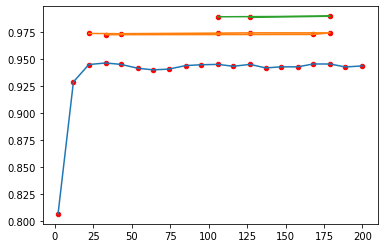

In [24]:
show_cv_results('n_estimators', clf_rf_1.cv_results_)

In [25]:
best_rf_1 = clf_rf_1.best_estimator_
best_rf_1

RandomForestClassifier(n_estimators=179, random_state=42)

In [26]:
y_val_pred_best_rf_1 = best_rf_1.predict(X_val)
f2_score(y_val, y_val_pred_best_rf_1)

0.6862745098039215

In [27]:
best_rf_1.feature_importances_

array([0.01680887, 0.02688682, 0.02478166, 0.00363385, 0.00360519,
       0.0091425 , 0.02227214, 0.06300992, 0.01275598, 0.03774334,
       0.00344026, 0.00316357, 0.00303613, 0.00962245, 0.00245658,
       0.00495204, 0.00798044, 0.00931527, 0.05318174, 0.00310815,
       0.00357107, 0.00405609, 0.02816495, 0.00270127, 0.00286701,
       0.00492083, 0.00420182, 0.00415486, 0.00592711, 0.01985801,
       0.00268352, 0.00258632, 0.00266761, 0.00847655, 0.01028741,
       0.04762785, 0.02059202, 0.02255093, 0.00247114, 0.02474922,
       0.00424977, 0.00785807, 0.03586905, 0.00291291, 0.00343248,
       0.00377941, 0.00541917, 0.00440896, 0.00574849, 0.00269742,
       0.00576672, 0.00423611, 0.00802211, 0.00244468, 0.00343775,
       0.0030916 , 0.00438321, 0.00415612, 0.00302581, 0.00639092,
       0.00503955, 0.00910161, 0.00369304, 0.00519992, 0.00266556,
       0.01101786, 0.00564232, 0.03731129, 0.03328545, 0.00357868,
       0.00596429, 0.00666626, 0.00231643, 0.0078906 , 0.00314

# Random forest (2/2)

## Setting up parameter grid and Random forest

In [28]:
n_estimators_rf_2 = np.unique(np.linspace(107, 126, num=20, dtype=int))
n_estimators_rf_2

array([107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126])

In [29]:
param_grid_rf_2 = {'n_estimators': n_estimators_rf_2}

In [30]:
rf_2 = RandomForestClassifier(random_state=RANDOM_STATE)
rf_2

RandomForestClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [31]:
clf_rf_2 = HalvingGridSearchCV(rf_2, param_grid_rf_2, scoring=f2_scorer, 
                               random_state=RANDOM_STATE)
clf_rf_2

HalvingGridSearchCV(estimator=RandomForestClassifier(random_state=42),
                    param_grid={'n_estimators': array([107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126])},
                    random_state=42, scoring=make_scorer(fbeta_score, beta=2))

In [32]:
clf_rf_2.fit(X_train_over, y_train_over)

HalvingGridSearchCV(estimator=RandomForestClassifier(random_state=42),
                    param_grid={'n_estimators': array([107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126])},
                    random_state=42, scoring=make_scorer(fbeta_score, beta=2))

In [33]:
clf_rf_2.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2]),
 'mean_fit_time': array([0.5775002 , 0.57380958, 0.57667975, 0.5803946 , 0.58431187,
        0.58824539, 0.59339557, 0.59927392, 0.60516133, 0.6113399 ,
        0.61146173, 0.62043452, 0.62194571, 0.63720136, 0.63663621,
        0.64427428, 0.64669681, 0.65235567, 0.65674829, 0.66397686,
        2.30717659, 2.10908871, 2.13257551, 2.28921499, 2.31688352,
        2.33588042, 1.98733482, 8.24895043, 8.333044  , 9.1444725 ]),
 'mean_score_time': array([0.01946483, 0.01453972, 0.01491566, 0.013873  , 0.01413817,
        0.01518965, 0.01444464, 0.01678925, 0.01460662, 0.01475844,
        0.01614909, 0.01808133, 0.01609368, 0.0151227 , 0.0159411 ,
        0.01543207, 0.01574593, 0.01567264, 0.01617889, 0.01697354,
        0.02506871, 0.02301397, 0.02303905, 0.02660155, 0.02695737,
        0.02524362, 0.02159734, 0.04889302, 0.04969926, 0.05217881]),
 'mean_test_score': array([0

,iter,n_estimators,mean_test_score,rank_test_score
0,0,107,0.946473,11
1,0,108,0.942706,20
2,0,109,0.942026,24
3,0,110,0.941334,30
4,0,111,0.942364,23
5,0,112,0.941335,29
6,0,113,0.942668,22
7,0,114,0.943317,16
8,0,115,0.944033,15
9,0,116,0.943011,18


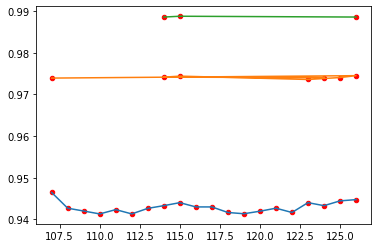

In [34]:
show_cv_results('n_estimators', clf_rf_2.cv_results_)

In [35]:
best_rf_2 = clf_rf_2.best_estimator_
best_rf_2

RandomForestClassifier(n_estimators=115, random_state=42)

In [36]:
y_val_pred_best_rf_2 = best_rf_2.predict(X_val)
f2_score(y_val, y_val_pred_best_rf_2)

0.6796116504854368

In [37]:
best_rf_2.feature_importances_

array([0.01668679, 0.02805429, 0.02006552, 0.00369455, 0.00370831,
       0.01219975, 0.03131383, 0.05668721, 0.01120838, 0.04317696,
       0.00332136, 0.00334176, 0.00293254, 0.00854428, 0.00221691,
       0.00450833, 0.00945449, 0.0061331 , 0.04746206, 0.00291405,
       0.00361378, 0.00498761, 0.03472541, 0.0027081 , 0.00301186,
       0.00561495, 0.00293263, 0.00379407, 0.00585745, 0.01649904,
       0.00262656, 0.0027161 , 0.00253341, 0.00592285, 0.01247111,
       0.05160061, 0.02000059, 0.02139226, 0.00243641, 0.02824601,
       0.00415768, 0.00574798, 0.03038315, 0.00300391, 0.00324069,
       0.0035673 , 0.00537667, 0.00431207, 0.00551205, 0.00255151,
       0.00546494, 0.00405767, 0.00856888, 0.00231704, 0.00347536,
       0.00289072, 0.00428161, 0.00290935, 0.00295558, 0.00667277,
       0.00348115, 0.00906621, 0.00350368, 0.00528218, 0.00286967,
       0.01027672, 0.00523291, 0.04521065, 0.03851334, 0.00340946,
       0.00554541, 0.00689739, 0.00223444, 0.00842323, 0.00344

# Bagging (1/2)

## Setting up parameter grid and Bagging

In [38]:
n_estimators_bagging_1 = np.unique(np.linspace(2, 20, num=10, dtype=int))
n_estimators_bagging_1

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [39]:
param_grid_bagging_1 = {'n_estimators': n_estimators_bagging_1}

In [40]:
bagging_1 = BaggingClassifier(random_state=RANDOM_STATE)
bagging_1

BaggingClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [41]:
clf_bagging_1 = HalvingGridSearchCV(bagging_1, param_grid_bagging_1,
                                    scoring=f2_scorer,
                                    random_state=RANDOM_STATE)
clf_bagging_1

HalvingGridSearchCV(estimator=BaggingClassifier(random_state=42),
                    param_grid={'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
                    random_state=42, scoring=make_scorer(fbeta_score, beta=2))

In [42]:
clf_bagging_1.fit(X_train_over, y_train_over)

HalvingGridSearchCV(estimator=BaggingClassifier(random_state=42),
                    param_grid={'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
                    random_state=42, scoring=make_scorer(fbeta_score, beta=2))

In [43]:
clf_bagging_1.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2]),
 'mean_fit_time': array([ 0.10370898,  0.19947081,  0.28589625,  0.38440056,  0.48647847,
         0.58425016,  0.68535852,  0.78508606,  0.88578396,  0.98951483,
         3.0266634 ,  2.58779225,  3.88414197,  4.30424323, 18.55446668,
        20.67869325]),
 'mean_score_time': array([0.00295944, 0.00283394, 0.00282722, 0.00315781, 0.0035398 ,
        0.00380673, 0.00435634, 0.00453668, 0.00480685, 0.00511475,
        0.00910583, 0.00817056, 0.01102471, 0.0131372 , 0.022018  ,
        0.02663774]),
 'mean_test_score': array([0.82291159, 0.88643719, 0.91274743, 0.91030833, 0.92021495,
        0.92705792, 0.92579767, 0.92431897, 0.93109   , 0.93236499,
        0.96059267, 0.95930885, 0.96238349, 0.96273574, 0.98287587,
        0.98248739]),
 'mean_train_score': array([0.93674569, 0.97347539, 0.98620623, 0.9910755 , 0.99447452,
        0.99640337, 0.9951835 , 0.99658745, 0.99816614, 0.99896032,
        0.99855492, 0.9984114

,iter,n_estimators,mean_test_score,rank_test_score
0,0,2,0.822912,16
1,0,4,0.886437,15
2,0,6,0.912747,13
3,0,8,0.910308,14
4,0,10,0.920215,12
5,0,12,0.927058,9
6,0,14,0.925798,10
7,0,16,0.924319,11
8,0,18,0.931090,8
9,0,20,0.932365,7


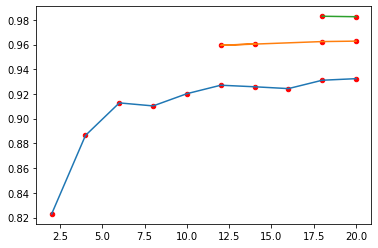

In [44]:
show_cv_results('n_estimators', clf_bagging_1.cv_results_)

In [45]:
best_bagging_1 = clf_bagging_1.best_estimator_
best_bagging_1

BaggingClassifier(n_estimators=18, random_state=42)

In [46]:
y_val_pred_best_bagging_1 = best_bagging_1.predict(X_val)
f2_score(y_val, y_val_pred_best_bagging_1)

0.42105263157894735

# Bagging (2/2)

## Setting up parameter grid and Bagging

In [47]:
n_estimators_bagging_2 = np.unique(np.linspace(16, 22, num=7, dtype=int))
n_estimators_bagging_2

array([16, 17, 18, 19, 20, 21, 22])

In [48]:
param_grid_bagging_2 = {'n_estimators': n_estimators_bagging_2}

In [49]:
bagging_2 = BaggingClassifier(random_state=RANDOM_STATE)
bagging_2

BaggingClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [50]:
clf_bagging_2 = HalvingGridSearchCV(bagging_2, param_grid_bagging_2, 
                                    scoring=f2_scorer,
                                    random_state=RANDOM_STATE)
clf_bagging_2

HalvingGridSearchCV(estimator=BaggingClassifier(random_state=42),
                    param_grid={'n_estimators': array([16, 17, 18, 19, 20, 21, 22])},
                    random_state=42, scoring=make_scorer(fbeta_score, beta=2))

In [51]:
clf_bagging_2.fit(X_train_over, y_train_over)

HalvingGridSearchCV(estimator=BaggingClassifier(random_state=42),
                    param_grid={'n_estimators': array([16, 17, 18, 19, 20, 21, 22])},
                    random_state=42, scoring=make_scorer(fbeta_score, beta=2))

In [52]:
clf_bagging_2.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1]),
 'mean_fit_time': array([ 3.50483646,  3.71162286,  3.93475876,  4.13415647,  4.35593295,
         4.57747908,  4.74241796, 22.75551906, 20.6725471 , 21.49891801]),
 'mean_score_time': array([0.01024742, 0.01068301, 0.01129627, 0.01200914, 0.01262927,
        0.01278429, 0.01315923, 0.02846766, 0.02509856, 0.02546258]),
 'mean_test_score': array([0.96417609, 0.96460664, 0.96362155, 0.96622442, 0.96454854,
        0.96633738, 0.96503221, 0.98315159, 0.98248037, 0.9834377 ]),
 'mean_train_score': array([0.99921911, 0.9992493 , 0.99950886, 0.99945211, 0.99939385,
        0.99950958, 0.99968277, 0.99975942, 0.99978834, 0.99974023]),
 'n_resources': array([ 3464,  3464,  3464,  3464,  3464,  3464,  3464, 10392, 10392,
        10392]),
 'param_n_estimators': masked_array(data=[16, 17, 18, 19, 20, 21, 22, 22, 19, 21],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value

,iter,n_estimators,mean_test_score,rank_test_score
0,0,16,0.964176,9
1,0,17,0.964607,7
2,0,18,0.963622,10
3,0,19,0.966224,5
4,0,20,0.964549,8
5,0,21,0.966337,4
6,0,22,0.965032,6
7,1,22,0.983152,2
8,1,19,0.982480,3
9,1,21,0.983438,1


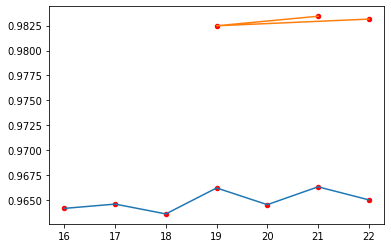

In [53]:
show_cv_results('n_estimators', clf_bagging_2.cv_results_)

In [54]:
best_bagging_2 = clf_bagging_2.best_estimator_
best_bagging_2

BaggingClassifier(n_estimators=21, random_state=42)

In [55]:
y_val_pred_best_bagging_2 = best_bagging_2.predict(X_val)
f2_score(y_val, y_val_pred_best_bagging_2)

0.46874999999999994

# AdaBoost (1/2)

## Setting up parameter grid and AdaBoost

In [56]:
n_estimators_ada_1 = np.unique(np.linspace(2, 100, num=10, dtype=int))
n_estimators_ada_1

array([  2,  12,  23,  34,  45,  56,  67,  78,  89, 100])

In [57]:
param_grid_ada_1 = {'n_estimators': n_estimators_ada_1}

In [58]:
ada_1 = AdaBoostClassifier(random_state=RANDOM_STATE)
ada_1

AdaBoostClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [59]:
clf_ada_1 = HalvingGridSearchCV(ada_1, param_grid_ada_1, scoring=f2_scorer)
clf_ada_1

HalvingGridSearchCV(estimator=AdaBoostClassifier(random_state=42),
                    param_grid={'n_estimators': array([  2,  12,  23,  34,  45,  56,  67,  78,  89, 100])},
                    scoring=make_scorer(fbeta_score, beta=2))

In [60]:
# clf_ada_1.fit(X_train_over, y_train_over)
clf_ada_1.fit(X_train_over, y_train_over)

HalvingGridSearchCV(estimator=AdaBoostClassifier(random_state=42),
                    param_grid={'n_estimators': array([  2,  12,  23,  34,  45,  56,  67,  78,  89, 100])},
                    scoring=make_scorer(fbeta_score, beta=2))

In [61]:
clf_ada_1.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2]),
 'mean_fit_time': array([ 0.02580113,  0.14599805,  0.28200316,  0.40766039,  0.54006534,
         0.67544489,  0.80412493,  0.94109941,  1.06540837,  1.19621005,
         2.36427832,  3.54151988,  3.16827426,  2.76494274, 11.02594128,
         9.81623764]),
 'mean_score_time': array([0.00148664, 0.00453038, 0.00566287, 0.00757537, 0.00945792,
        0.01195617, 0.01345816, 0.01571813, 0.01826506, 0.02160029,
        0.0290379 , 0.04105635, 0.03589849, 0.03082905, 0.07890205,
        0.0704042 ]),
 'mean_test_score': array([0.87402821, 0.90545474, 0.93101822, 0.94005156, 0.93708093,
        0.94241939, 0.94497837, 0.95184941, 0.95067638, 0.94537449,
        0.94825006, 0.95718836, 0.95724323, 0.95408772, 0.96491698,
        0.96328888]),
 'mean_train_score': array([0.88428889, 0.93317018, 0.96896779, 0.98204162, 0.98973538,
        0.99625349, 0.99873339, 0.99966302, 1.        , 1.        ,
        0.98034954, 0.9909375

,iter,n_estimators,mean_test_score,rank_test_score
0,0,2,0.874028,16
1,0,12,0.905455,15
2,0,23,0.931018,14
3,0,34,0.940052,12
4,0,45,0.937081,13
5,0,56,0.942419,11
6,0,67,0.944978,10
7,0,78,0.951849,6
8,0,89,0.950676,7
9,0,100,0.945374,9


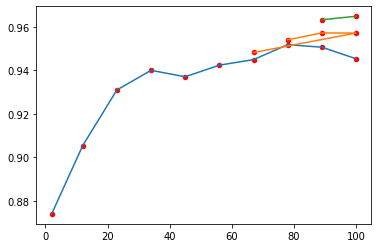

In [62]:
show_cv_results('n_estimators', clf_ada_1.cv_results_)

In [63]:
best_ada_1 = clf_ada_1.best_estimator_
best_ada_1

AdaBoostClassifier(n_estimators=100, random_state=42)

In [64]:
y_val_pred_best_ada_1 = best_ada_1.predict(X_val)
f2_score(y_val, y_val_pred_best_ada_1)

0.4910714285714286

# AdaBoost (2/2)

## Setting up parameter grid and AdaBoost

In [65]:
n_estimators_ada_2 = np.unique(np.linspace(85, 104, num=20, dtype=int))
n_estimators_ada_2

array([ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104])

In [66]:
param_grid_ada_2 = {'n_estimators': n_estimators_ada_2}

In [67]:
ada_2 = AdaBoostClassifier(random_state=RANDOM_STATE)
ada_2

AdaBoostClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [68]:
clf_ada_2 = HalvingGridSearchCV(ada_2, param_grid_ada_2, scoring=f2_scorer)
clf_ada_2

HalvingGridSearchCV(estimator=AdaBoostClassifier(random_state=42),
                    param_grid={'n_estimators': array([ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104])},
                    scoring=make_scorer(fbeta_score, beta=2))

In [69]:
clf_ada_2.fit(X_train_over, y_train_over)

HalvingGridSearchCV(estimator=AdaBoostClassifier(random_state=42),
                    param_grid={'n_estimators': array([ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104])},
                    scoring=make_scorer(fbeta_score, beta=2))

In [70]:
clf_ada_2.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2]),
 'mean_fit_time': array([ 1.04782319,  1.03443499,  1.04256396,  1.05285802,  1.0663003 ,
         1.08068047,  1.09190493,  1.10747142,  1.1188766 ,  1.12471766,
         1.13928123,  1.15579548,  1.16658916,  1.17227311,  1.18548408,
         1.41012807,  1.21941495,  1.22660713,  1.24119072,  1.2564229 ,
         3.37431979,  3.47766995,  3.33414302,  3.28817258,  3.12164283,
         3.45420637,  3.26159992, 10.44313631, 10.73705893, 10.16883025]),
 'mean_score_time': array([0.01700087, 0.01865711, 0.01759052, 0.01750631, 0.01837177,
        0.01811471, 0.01835842, 0.01891279, 0.01912503, 0.01929674,
        0.01917691, 0.02106209, 0.01936884, 0.0210021 , 0.02052283,
        0.02423062, 0.02019281, 0.02013936, 0.02046862, 0.02066259,
        0.04018493, 0.03845553, 0.03815064, 0.03690953, 0.03626218,
        0.03881083, 0.03692498, 0.07328997, 0.07602897, 0.07087874])

,iter,n_estimators,mean_test_score,rank_test_score
0,0,85,0.945781,30
1,0,86,0.948825,22
2,0,87,0.947445,28
3,0,88,0.951841,13
4,0,89,0.949466,21
5,0,90,0.949815,20
6,0,91,0.949885,19
7,0,92,0.953240,11
8,0,93,0.951489,14
9,0,94,0.951460,15


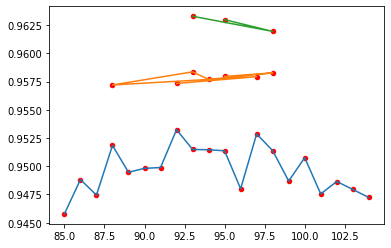

In [71]:
show_cv_results('n_estimators', clf_ada_2.cv_results_)

In [72]:
best_ada_2 = clf_ada_2.best_estimator_
best_ada_2

AdaBoostClassifier(n_estimators=93, random_state=42)

In [73]:
y_val_pred_best_ada_2 = best_ada_2.predict(X_val)
f2_score(y_val, y_val_pred_best_ada_2)

0.5982905982905984

# Gradient Boosting (1/2)

## Setting up parameter grid and Gradient Boosting

In [74]:
n_estimators_gb_1 = np.unique(np.linspace(2, 200, num=20, dtype=int))
n_estimators_gb_1

array([  2,  12,  22,  33,  43,  54,  64,  74,  85,  95, 106, 116, 127,
       137, 147, 158, 168, 179, 189, 200])

In [75]:
param_grid_gb_1 = {'n_estimators': n_estimators_gb_1}

In [76]:
gb_1 = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_1

GradientBoostingClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [77]:
clf_gb_1 = HalvingGridSearchCV(gb_1, param_grid_gb_1, scoring=f2_scorer)
clf_gb_1

HalvingGridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                    param_grid={'n_estimators': array([  2,  12,  22,  33,  43,  54,  64,  74,  85,  95, 106, 116, 127,
       137, 147, 158, 168, 179, 189, 200])},
                    scoring=make_scorer(fbeta_score, beta=2))

In [78]:
clf_gb_1.fit(X_train_over, y_train_over)

HalvingGridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                    param_grid={'n_estimators': array([  2,  12,  22,  33,  43,  54,  64,  74,  85,  95, 106, 116, 127,
       137, 147, 158, 168, 179, 189, 200])},
                    scoring=make_scorer(fbeta_score, beta=2))

In [79]:
clf_gb_1.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2]),
 'mean_fit_time': array([4.85991001e-02, 2.92141676e-01, 5.24961472e-01, 7.82886553e-01,
        1.01526051e+00, 1.28248019e+00, 1.51549101e+00, 1.75869684e+00,
        2.02323337e+00, 2.26044540e+00, 2.52422318e+00, 2.76924706e+00,
        3.03115630e+00, 3.28229394e+00, 3.52555847e+00, 3.78314776e+00,
        4.02378001e+00, 4.53886795e+00, 4.52233701e+00, 4.79265094e+00,
        1.08442469e+01, 1.16402262e+01, 1.25061940e+01, 1.49906808e+01,
        1.41864987e+01, 1.33189538e+01, 1.61180585e+01, 4.69691977e+01,
        5.28168853e+01, 4.95297674e+01]),
 'mean_score_time': array([0.00141935, 0.00170546, 0.00158615, 0.00169997, 0.00167241,
        0.00176778, 0.00181656, 0.00188422, 0.00189705, 0.00209603,
        0.00222287, 0.00224547, 0.0023212 , 0.00216222, 0.00226107,
        0.00227122, 0.00231509, 0.00246272, 0.00239377, 0.00243845,
        0.00373945, 0.00394573

,iter,n_estimators,mean_test_score,rank_test_score
0,0,2,0.911714,30
1,0,12,0.926210,29
2,0,22,0.926837,28
3,0,33,0.930112,27
4,0,43,0.932715,26
5,0,54,0.942557,25
6,0,64,0.943402,24
7,0,74,0.950214,22
8,0,85,0.950214,22
9,0,95,0.951919,21


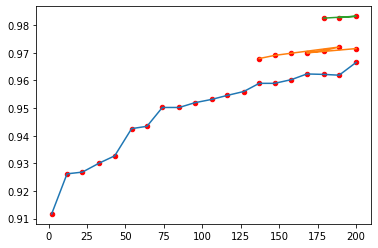

In [80]:
show_cv_results('n_estimators', clf_gb_1.cv_results_)

In [81]:
best_gb_1 = clf_gb_1.best_estimator_
best_gb_1

GradientBoostingClassifier(n_estimators=200, random_state=42)

In [82]:
y_val_pred_best_gb_1 = best_gb_1.predict(X_val)
f2_score(y_val, y_val_pred_best_gb_1)

0.6363636363636362

# Gradient Boosting (2/2)

## Setting up parameter grid and Gradient Boosting

In [83]:
n_estimators_gb_2 = np.unique(np.linspace(180, 200, num=10, dtype=int))
n_estimators_gb_2

array([180, 182, 184, 186, 188, 191, 193, 195, 197, 200])

In [84]:
param_grid_gb_2 = {'n_estimators': n_estimators_gb_2}

In [85]:
gb_2 = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_2

GradientBoostingClassifier(random_state=42)

## Performing grid search cross validation and choosing the best model

In [86]:
clf_gb_2 = HalvingGridSearchCV(gb_2, param_grid_gb_2, scoring=f2_scorer)
clf_gb_2

HalvingGridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                    param_grid={'n_estimators': array([180, 182, 184, 186, 188, 191, 193, 195, 197, 200])},
                    scoring=make_scorer(fbeta_score, beta=2))

In [87]:
clf_gb_2.fit(X_train_over, y_train_over)

HalvingGridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                    param_grid={'n_estimators': array([180, 182, 184, 186, 188, 191, 193, 195, 197, 200])},
                    scoring=make_scorer(fbeta_score, beta=2))

In [88]:
clf_gb_2.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2]),
 'mean_fit_time': array([ 4.33164306,  4.36514707,  4.40388455,  4.45488276,  4.51746588,
         4.58945189,  4.89521537,  4.67333817,  4.72007914,  4.79710588,
        15.48869877, 15.67462273, 14.44206247, 14.76477075, 48.05436835,
        51.65881166]),
 'mean_score_time': array([0.0023746 , 0.00240378, 0.00241046, 0.00242538, 0.00248542,
        0.00268288, 0.00272479, 0.00246511, 0.00268493, 0.002494  ,
        0.00446272, 0.00443673, 0.00427141, 0.0043292 , 0.00986714,
        0.01034532]),
 'mean_test_score': array([0.95843069, 0.95956371, 0.95809091, 0.96022824, 0.95889049,
        0.95783985, 0.95783985, 0.95923113, 0.95923113, 0.95785336,
        0.9736039 , 0.97451963, 0.97407879, 0.97383016, 0.98347322,
        0.98389612]),
 'mean_train_score': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99889697, 0.9988969

,iter,n_estimators,mean_test_score,rank_test_score
0,0,180,0.958431,12
1,0,182,0.959564,8
2,0,184,0.958091,13
3,0,186,0.960228,7
4,0,188,0.958890,11
5,0,191,0.957840,15
6,0,193,0.957840,15
7,0,195,0.959231,9
8,0,197,0.959231,9
9,0,200,0.957853,14


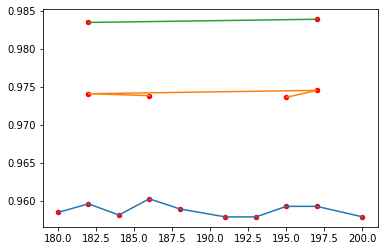

In [89]:
show_cv_results('n_estimators', clf_gb_2.cv_results_)

In [90]:
best_gb_2 = clf_gb_2.best_estimator_
best_gb_2

GradientBoostingClassifier(n_estimators=197, random_state=42)

In [91]:
y_val_pred_best_gb_2 = best_gb_2.predict(X_val)
f2_score(y_val, y_val_pred_best_gb_2)

0.6422018348623852

# Stacking

# Information

## Notebook approximated execution time

In [92]:
end_time = time.time()
running_time = end_time - start_time
print(f'Time in seconds             {running_time}')
print(f'Time in hour:minute:second  \
{str(datetime.timedelta(seconds=running_time))}')

Time in seconds             4677.761944055557
Time in hour:minute:second  1:17:57.761944


## Hardware specifications

In [93]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   39G   70G  36% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  812M  59% /sbin/docker-init
tmpfs           6.4G   36K  6.4G   1% /var/colab
/dev/sda1        81G   43G   39G  53% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  5.7G  9.4G  38% /content/drive


In [94]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.142
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.28
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [95]:
!cat /proc/meminfo

MemTotal:       13298580 kB
MemFree:         9676428 kB
MemAvailable:   11835480 kB
Buffers:          121044 kB
Cached:          2066880 kB
SwapCached:            0 kB
Active:          1761780 kB
Inactive:        1650060 kB
Active(anon):    1056472 kB
Inactive(anon):      448 kB
Active(file):     705308 kB
Inactive(file):  1649612 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               756 kB
Writeback:             0 kB
AnonPages:       1223752 kB
Mapped:           318436 kB
Shmem:              1204 kB
KReclaimable:      91168 kB
Slab:             135900 kB
SReclaimable:      91168 kB
SUnreclaim:        44732 kB
KernelStack:        5904 kB
PageTables:        17308 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6649288 kB
Committed_AS:    3915732 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        8408 kB
VmallocChunk:          0 kB
Percpu:          

## Versions

In [96]:
!python --version

Python 3.7.13


In [97]:
np.__version__

'1.21.6'

In [98]:
pd.__version__

'1.3.5'

In [99]:
matplotlib.__version__

'3.2.2'

In [100]:
sklearn.__version__

'1.0.2'

In [101]:
imblearn.__version__

'0.8.1'